In [556]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import string
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_log_error,mean_squared_error,roc_auc_score
from sklearn import metrics
from sklearn.linear_model import SGDRegressor,LinearRegression,Lasso,Ridge
from sklearn.ensemble import RandomForestRegressor,GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import time
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.pipeline import Pipeline
from math import sqrt
from scipy.sparse import csr_matrix, hstack
from sklearn.svm import SVR
from sklearn import preprocessing
import xgboost as xgb
from sklearn.decomposition import PCA
import datetime as dt
from datetime import timedelta

In [624]:
data = pd.read_csv('./data/Data_Train.csv')

In [625]:
data.head()

,Unique_ID,Name,Genre,Country,Song_Name,Timestamp,Views,Comments,Likes,Popularity,Followers
0,413890,Hardstyle,danceedm,AU,N-Vitral presents BOMBSQUAD - Poison Spitter (...,2018-03-30 15:24:45.000000,14017,4,499,97,119563
1,249453,Dj Aladdin,danceedm,AU,Dj Aladdin - Old School Hip Hop Quick Mix,2016-06-20 05:58:52.000000,1918,17,49,17,2141
2,681116,Maxximize On Air,danceedm,AU,Maxximize On Air - Mixed by Blasterjaxx - Epis...,2015-05-08 17:45:59.000000,9668,11,312,91,22248
3,387253,GR6 EXPLODE,rbsoul,AU,MC Yago - Tenho Compromisso (DJ R7),2017-06-08 23:50:03.000000,113036,2,"2,400",76,393655
4,1428029,Tritonal,danceedm,AU,Escape (feat. Steph Jones),2016-09-17 20:50:19.000000,110024,81,"3,031",699,201030


In [626]:
data.drop(columns=['Unique_ID','Country','Name'],axis=1,inplace=True)

In [627]:
#data = pd.get_dummies(data,columns=['Genre'],drop_first=True)
data[data['Song_Name'].duplicated()]

,Genre,Song_Name,Timestamp,Views,Comments,Likes,Popularity,Followers


In [628]:
data['Timestamp'] =pd.to_datetime(data['Timestamp'])
data['dayofweek'] = data['Timestamp'].dt.dayofweek #but mostly people on weekend
data['weekend'] = data['dayofweek'].apply(lambda x: 1 if (x>4)  else 0)
display(data.groupby(['dayofweek'])['Views'].mean())
display(data.groupby(['weekend'])['Views'].mean())

dayofweek
0    464738.026194
1    490431.424895
2    492227.829528
3    527652.001258
4    712625.466029
5    447178.314718
6    603471.317145
Name: Views, dtype: float64

weekend
0    551470.332289
1    517781.487123
Name: Views, dtype: float64

In [629]:
#trying for time as feature
display(data[data['Timestamp']==data['Timestamp'].min()])
display(data[data['Timestamp']==data['Timestamp'].max()])
data.sort_values(by=['Timestamp']).groupby(['Timestamp'])['Views'].value_counts()
data['dayofweek'] = data['Timestamp'].dt.dayofweek #but mostly people on weekend
data['weekend'] = data['dayofweek'].apply(lambda x: 1 if (x>4)  else 0)

,Genre,Song_Name,Timestamp,Views,Comments,Likes,Popularity,Followers,dayofweek,weekend
8583,rock,My Fairy King,1973-01-01,141,1,5,0,70299,0,0
14326,rock,Liar (At The BBC),1973-01-01,87,0,0,0,70299,0,0
14653,rock,Keep Yourself Alive,1973-01-01,1086,0,14,0,70299,0,0
49988,rock,Doing All Right,1973-01-01,618,0,14,0,70299,0,0
61074,rock,Great King Rat,1973-01-01,104,0,0,0,70299,0,0


,Genre,Song_Name,Timestamp,Views,Comments,Likes,Popularity,Followers,dayofweek,weekend
72376,danceedm,Sam Feldt - Heartfeldt Radio #164,2019-02-25 08:00:06,35,0,7,3,23043,0,0


In [630]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78458 entries, 0 to 78457
Data columns (total 10 columns):
Genre         78458 non-null object
Song_Name     78457 non-null object
Timestamp     78458 non-null datetime64[ns]
Views         78458 non-null int64
Comments      78458 non-null int64
Likes         78458 non-null object
Popularity    78458 non-null object
Followers     78458 non-null int64
dayofweek     78458 non-null int64
weekend       78458 non-null int64
dtypes: datetime64[ns](1), int64(5), object(4)
memory usage: 6.0+ MB


In [631]:
def popularityConverting(x):
    if x[-1]=='K':
        x= ''.join(x[:-1].split(','))
        x=float(x)*1000
    elif x[-1]=='M':
        x= ''.join(x[:-1].split(','))
        x=float(x)*1000000
    else:
        x= ''.join(x.split(','))
    return x

In [632]:
data['Popularity'] = data.Popularity.apply(popularityConverting)
data['Popularity'] = data.Popularity.astype('float')
data['Likes'] = data.Likes.apply(popularityConverting)
data['Likes'] = data.Likes.astype('float')

In [633]:
NOW = dt.datetime(2019, 2, 27)
data['date_old']=(NOW-data['Timestamp']).dt.days
data['like_per_date']=data['Likes']/data['date_old']
data['followers_per_date']=data['Followers']/data['date_old']
data['Popularity_per_date']=data['Popularity']/data['date_old']
data.head()
#data['date_old'].min()

,Genre,Song_Name,Timestamp,Views,Comments,Likes,Popularity,Followers,dayofweek,weekend,date_old,like_per_date,followers_per_date,Popularity_per_date
0,danceedm,N-Vitral presents BOMBSQUAD - Poison Spitter (...,2018-03-30 15:24:45,14017,4,499.0,97.0,119563,4,0,333,1.498498,359.048048,0.291291
1,danceedm,Dj Aladdin - Old School Hip Hop Quick Mix,2016-06-20 05:58:52,1918,17,49.0,17.0,2141,0,0,981,0.049949,2.182467,0.017329
2,danceedm,Maxximize On Air - Mixed by Blasterjaxx - Epis...,2015-05-08 17:45:59,9668,11,312.0,91.0,22248,4,0,1390,0.224460,16.005755,0.065468
3,rbsoul,MC Yago - Tenho Compromisso (DJ R7),2017-06-08 23:50:03,113036,2,2400.0,76.0,393655,3,0,628,3.821656,626.839172,0.121019
4,danceedm,Escape (feat. Steph Jones),2016-09-17 20:50:19,110024,81,3031.0,699.0,201030,5,1,892,3.397982,225.369955,0.783632


In [634]:
#pd.plotting.scatter_matrix(data, alpha=0.3, figsize=(14,8), diagonal='kde');

In [635]:

data.head()

,Genre,Song_Name,Timestamp,Views,Comments,Likes,Popularity,Followers,dayofweek,weekend,date_old,like_per_date,followers_per_date,Popularity_per_date
0,danceedm,N-Vitral presents BOMBSQUAD - Poison Spitter (...,2018-03-30 15:24:45,14017,4,499.0,97.0,119563,4,0,333,1.498498,359.048048,0.291291
1,danceedm,Dj Aladdin - Old School Hip Hop Quick Mix,2016-06-20 05:58:52,1918,17,49.0,17.0,2141,0,0,981,0.049949,2.182467,0.017329
2,danceedm,Maxximize On Air - Mixed by Blasterjaxx - Epis...,2015-05-08 17:45:59,9668,11,312.0,91.0,22248,4,0,1390,0.224460,16.005755,0.065468
3,rbsoul,MC Yago - Tenho Compromisso (DJ R7),2017-06-08 23:50:03,113036,2,2400.0,76.0,393655,3,0,628,3.821656,626.839172,0.121019
4,danceedm,Escape (feat. Steph Jones),2016-09-17 20:50:19,110024,81,3031.0,699.0,201030,5,1,892,3.397982,225.369955,0.783632


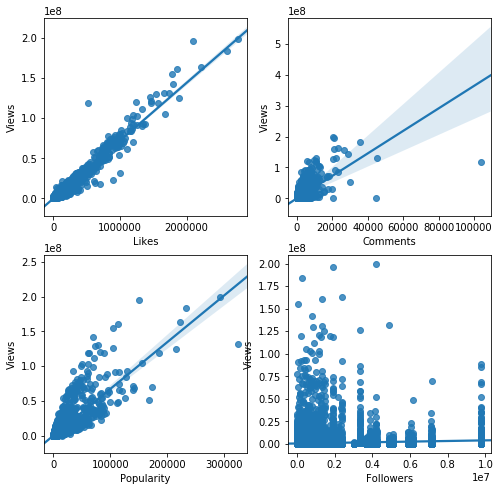

In [636]:
plt.figure(figsize=(8,8))
plt.subplot(2,2,1)
sns.regplot(x="Likes", y="Views", data=data)
plt.subplot(2,2,2)
sns.regplot(x="Comments", y="Views", data=data)
plt.subplot(2,2,3)
sns.regplot(x="Popularity", y="Views", data=data)
plt.subplot(2,2,4)
sns.regplot(x="Followers", y="Views", data=data)

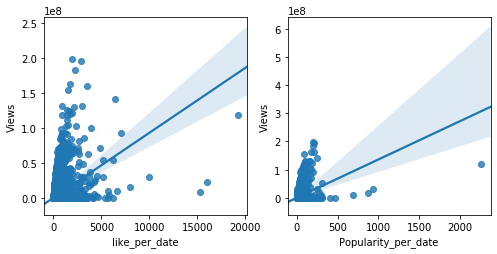

In [504]:
plt.figure(figsize=(8,8))
plt.subplot(2,2,1)
sns.regplot(x="like_per_date", y="Views", data=data)
plt.subplot(2,2,2)
sns.regplot(x="Popularity_per_date", y="Views", data=data)

In [605]:
def text_process(text):
    
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = [word for word in text.split() if word.lower() not in stopwords.words('english')]
    
    return " ".join(text)
data['Song_Name']=data['Song_Name'].astype('str')
#data['Song_Name'] = data['Song_Name'].apply(text_process)

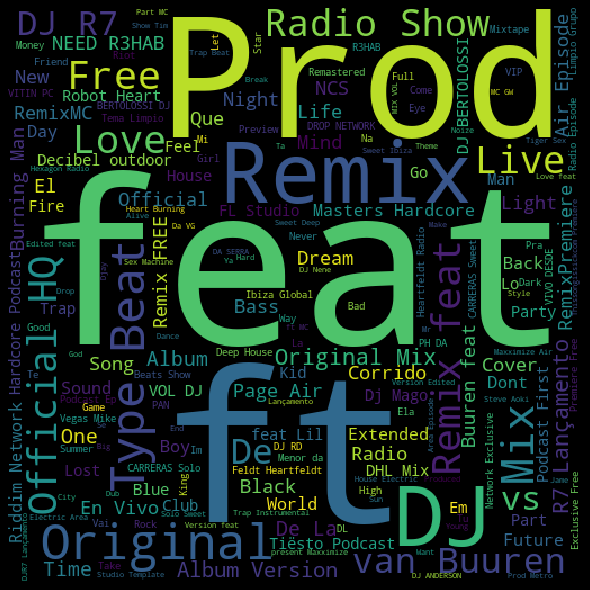

In [510]:
# visualizing the song text words using wordcloud
#add below also there
song_title = ''.join(list(data['Song_Name']))
song_title_cloud = WordCloud(width=512, height=512).generate(song_title)
plt.figure(figsize=(10,8), facecolor='k')
plt.imshow(song_title_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [511]:
print(Counter(" ".join(data["Song_Name"]).split()).most_common()[:10])
Counter(" ".join(data["Song_Name"]).split()).most_common()[-10:]

[('Remix', 9366), ('feat', 6641), ('DJ', 5114), ('MC', 4784), ('Mix', 4075), ('Premiere', 2615), ('ft', 2137), ('2018', 2063), ('Radio', 1872), ('x', 1798)]


[('C14TORCE', 1),
 ('IImp3', 1),
 ('Adding', 1),
 ('S03E41', 1),
 ('KAMI', 1),
 ('Audiotorium', 1),
 ('RA505', 1),
 ('Lurtz', 1),
 ('ELLLL', 1),
 ('SKITTLES', 1)]

In [609]:
display(data[data['Song_Name'].str.contains("Remix")].head())
data[data['Song_Name'].str.contains("SKITTLES")].head()

,Genre,Song_Name,Timestamp,Views,Comments,Likes,Popularity,Followers,dayofweek,weekend,date_old,like_per_date,followers_per_date,Popularity_per_date
6,danceedm,Coone - Universal Language (Cyber Remix),2016-01-22 17:23:26,37480,15,1017.0,226.0,119563,4,0,1131,0.899204,105.714412,0.199823
7,danceedm,Pick Your Poison (feat. Kay) (Figure Remix),2012-01-17 00:00:00,4022,5,88.0,12.0,7120051,1,0,2598,0.033872,2740.589299,0.004619
18,electronic,Big Sean - My Last (AC Slater Remix),2011-10-27 23:28:43,26587,45,408.0,35.0,113537,3,0,2679,0.152296,42.380366,0.013065
27,all-music,Leyla (Mysterymen Remix) [feat. Fuse ODG],2015-08-14 00:00:00,2862,0,39.0,1.0,14652,4,0,1293,0.030162,11.331787,0.000773
29,classical,Catey Shaw - Human Contact (Speaker Of The Hou...,2015-04-25 17:58:27,380818,61,7137.0,1453.0,738781,5,1,1403,5.086957,526.572345,1.035638


,Genre,Song_Name,Timestamp,Views,Comments,Likes,Popularity,Followers,dayofweek,weekend,date_old,like_per_date,followers_per_date,Popularity_per_date
78455,electronic,Premiere: ELLLL 'SKITTLES',2019-02-11 13:15:05,3621,1,157.0,31.0,1403057,0,0,15,10.466667,93537.133333,2.066667


In [514]:
data.groupby(['Genre'])['Views'].mean()

Genre
all-music               2.451156e+06
alternativerock         8.545917e+05
ambient                 3.985286e+05
classical               3.931904e+05
country                 2.945058e+05
danceedm                2.667007e+05
deephouse               6.264949e+04
disco                   3.681520e+05
drumbass                3.712738e+04
dubstep                 2.407431e+05
electronic              1.736503e+05
folksingersongwriter    4.753422e+05
hiphoprap               2.145161e+06
indie                   1.657772e+06
latin                   2.364045e+05
metal                   1.288263e+05
pop                     3.608129e+05
rbsoul                  6.094165e+05
reggaeton               1.149190e+06
rock                    1.325153e+05
trap                    2.763905e+05
Name: Views, dtype: float64

In [611]:
data.corr()

,Views,Comments,Likes,Popularity,Followers,dayofweek,weekend,date_old,like_per_date,followers_per_date,Popularity_per_date,Comments_per_date
Views,1.000000,0.679104,0.980132,0.834635,0.103603,0.014646,-0.002952,0.008631,0.459671,0.004738,0.437701,0.164297
Comments,0.679104,1.000000,0.656645,0.641815,0.085034,-0.001844,-0.002394,0.006911,0.540793,0.012754,0.674043,0.604662
Likes,0.980132,0.656645,1.000000,0.869048,0.110321,0.014117,-0.006747,0.003697,0.478396,0.005665,0.418447,0.097813
Popularity,0.834635,0.641815,0.869048,1.000000,0.138454,-0.006822,-0.013047,0.041307,0.293431,0.000447,0.374553,0.085795
Followers,0.103603,0.085034,0.110321,0.138454,1.000000,-0.031933,-0.076020,0.179521,0.039548,0.177716,0.047431,0.009067
dayofweek,0.014646,-0.001844,0.014117,-0.006822,-0.031933,1.000000,0.631842,-0.097366,0.021863,0.021561,0.012200,0.001300
weekend,-0.002952,-0.002394,-0.006747,-0.013047,-0.076020,0.631842,1.000000,-0.025410,-0.013657,-0.015942,-0.013168,-0.002626
date_old,0.008631,0.006911,0.003697,0.041307,0.179521,-0.097366,-0.025410,1.000000,-0.068361,-0.061376,-0.062461,-0.020385
like_per_date,0.459671,0.540793,0.478396,0.293431,0.039548,0.021863,-0.013657,-0.068361,1.000000,0.090037,0.807086,0.516965
followers_per_date,0.004738,0.012754,0.005665,0.000447,0.177716,0.021561,-0.015942,-0.061376,0.090037,1.000000,0.095805,0.038732


In [508]:
data.describe()
#if mean and median not equal outliers ??

,Views,Comments,Likes,Popularity,Followers,dayofweek,weekend,date_old,like_per_date,followers_per_date,Popularity_per_date
count,7.845800e+04,78458.000000,7.845800e+04,78458.000000,7.845800e+04,78458.000000,78458.000000,78458.000000,78458.000000,7.845800e+04,78458.000000
mean,5.469686e+05,115.270973,8.821458e+03,920.825524,4.787663e+05,2.579609,0.133626,994.561396,22.304360,1.608065e+03,1.725851
std,3.883085e+06,724.614868,5.277438e+04,4810.374304,1.168120e+06,1.785213,0.340252,1018.425867,191.923105,1.792704e+04,12.507931
min,0.000000e+00,0.000000,0.000000e+00,0.000000,1.000000e+00,0.000000,0.000000,1.000000,0.000000,9.269988e-03,0.000000
25%,6.216500e+03,1.000000,1.290000e+02,13.000000,1.770000e+04,1.000000,0.000000,298.000000,0.200452,2.933049e+01,0.021021
50%,2.538650e+04,12.000000,6.660000e+02,87.000000,8.768200e+04,3.000000,0.000000,767.000000,1.297592,1.255295e+02,0.168448
75%,1.201342e+05,61.000000,2.856750e+03,405.000000,3.936550e+05,4.000000,0.000000,1403.000000,6.182955,5.513894e+02,0.845766
max,1.994050e+08,104082.000000,2.770000e+06,324000.000000,9.789123e+06,6.000000,1.000000,16858.000000,19222.222222,1.780013e+06,2262.962963


In [637]:
features_data =data.loc[:,['Comments', 'Likes', 'Popularity','like_per_date','Popularity_per_date','Followers']]
features_data.head()

,Comments,Likes,Popularity,like_per_date,Popularity_per_date,Followers
0,4,499.0,97.0,1.498498,0.291291,119563
1,17,49.0,17.0,0.049949,0.017329,2141
2,11,312.0,91.0,0.224460,0.065468,22248
3,2,2400.0,76.0,3.821656,0.121019,393655
4,81,3031.0,699.0,3.397982,0.783632,201030


In [638]:
X = data.loc[:,['Comments', 'Likes', 'Popularity','like_per_date','Popularity_per_date','Followers']]
y = data['Views']

In [639]:
#pd.plotting.scatter_matrix(data.loc[:,['Views','Comments', 'Likes', 'Popularity', 'Followers','weekend']], alpha=0.3, figsize=(14,8), diagonal='kde');
data.corr()

,Views,Comments,Likes,Popularity,Followers,dayofweek,weekend,date_old,like_per_date,followers_per_date,Popularity_per_date
Views,1.000000,0.679104,0.980132,0.834635,0.103603,0.014646,-0.002952,0.008631,0.459671,0.004738,0.437701
Comments,0.679104,1.000000,0.656645,0.641815,0.085034,-0.001844,-0.002394,0.006911,0.540793,0.012754,0.674043
Likes,0.980132,0.656645,1.000000,0.869048,0.110321,0.014117,-0.006747,0.003697,0.478396,0.005665,0.418447
Popularity,0.834635,0.641815,0.869048,1.000000,0.138454,-0.006822,-0.013047,0.041307,0.293431,0.000447,0.374553
Followers,0.103603,0.085034,0.110321,0.138454,1.000000,-0.031933,-0.076020,0.179521,0.039548,0.177716,0.047431
dayofweek,0.014646,-0.001844,0.014117,-0.006822,-0.031933,1.000000,0.631842,-0.097366,0.021863,0.021561,0.012200
weekend,-0.002952,-0.002394,-0.006747,-0.013047,-0.076020,0.631842,1.000000,-0.025410,-0.013657,-0.015942,-0.013168
date_old,0.008631,0.006911,0.003697,0.041307,0.179521,-0.097366,-0.025410,1.000000,-0.068361,-0.061376,-0.062461
like_per_date,0.459671,0.540793,0.478396,0.293431,0.039548,0.021863,-0.013657,-0.068361,1.000000,0.090037,0.807086
followers_per_date,0.004738,0.012754,0.005665,0.000447,0.177716,0.021561,-0.015942,-0.061376,0.090037,1.000000,0.095805


In [640]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

[0.66023161 0.22290287 0.06994483 0.03354944 0.01337125]
[0.66023161 0.88313449 0.95307931 0.98662875 1.        ]


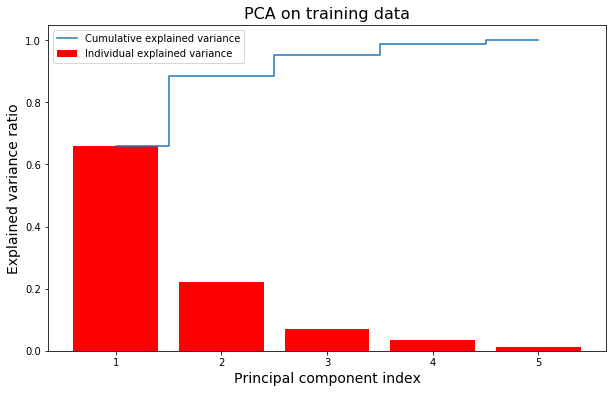

In [518]:
# Build PCA using standarized trained data
pca = PCA(n_components=None, svd_solver="full")
pca.fit(StandardScaler().fit_transform(X_train))
print(pca.explained_variance_ratio_)
cum_var_exp = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(10, 6))
plt.bar(range(1, 6), pca.explained_variance_ratio_, align="center",
        color='red', label="Individual explained variance")
plt.step(range(1, 6), cum_var_exp, where="mid", label="Cumulative explained variance")
plt.xticks(range(1, 6))
plt.legend(loc="best")
plt.xlabel("Principal component index", {"fontsize": 14})
plt.ylabel("Explained variance ratio", {"fontsize": 14})
plt.title("PCA on training data", {"fontsize": 16});
print(cum_var_exp)

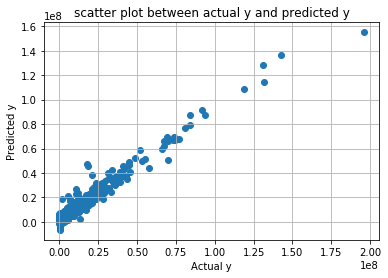

RMSE: 694043.372562


In [641]:
lr_regressor =LinearRegression()
lr_regressor.fit(X_train, y_train)
preds = lr_regressor.predict(X_test)
plt.scatter(y_test,preds)
plt.grid()
plt.xlabel('Actual y')
plt.ylabel('Predicted y')
plt.title('scatter plot between actual y and predicted y')
plt.show()
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))


In [591]:
lasso_params = {'alpha':[0.005,0.001, 0.02, 0.03, 0.05, 0.06]}
laso_regressor=Lasso()
laso_regressor_cv=GridSearchCV(laso_regressor,lasso_params,cv=5)
laso_regressor_cv.fit(X,y)
print("tuned hpyerparameters :(best parameters) ",laso_regressor_cv.best_params_)
print("accuracy :",laso_regressor_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'alpha': 0.001}
accuracy : 0.9661629998613648


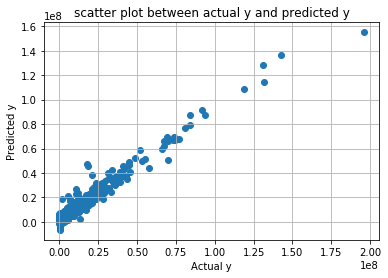

RMSE: 694043.371622


In [592]:
laso_regressor =Lasso(alpha= 0.001)
laso_regressor.fit(X_train, y_train)
preds = laso_regressor.predict(X_test)
plt.scatter(y_test,preds)
plt.grid()
plt.xlabel('Actual y')
plt.ylabel('Predicted y')
plt.title('scatter plot between actual y and predicted y')
plt.show()
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

In [522]:
rf_regressor= RandomForestRegressor()
hyperparam_grid={"n_estimators": [10, 50, 100],"max_features": ["sqrt", "log2", 0.4, 0.5],\
                 "min_samples_leaf": [1, 3, 5],'max_depth':[5,10,15,30]}
rf_regressor_cv = GridSearchCV(rf_regressor,hyperparam_grid,cv=2)
rf_regressor_cv.fit(X,y)
print("tuned hpyerparameters :(best parameters) ",rf_regressor_cv.best_params_)
print("accuracy :",rf_regressor_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 100}
accuracy : 0.9657336398901597


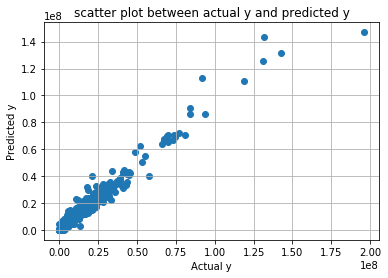

RMSE: 604534.085076


In [642]:
rf_regressor=RandomForestRegressor(max_depth= 30,max_features= 'sqrt', min_samples_leaf= 1, n_estimators=100)
rf_regressor.fit(X_train,y_train)

preds = rf_regressor.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
plt.scatter(y_test,preds)
plt.grid()
plt.xlabel('Actual y')
plt.ylabel('Predicted y')
plt.title('scatter plot between actual y and predicted y')
plt.show()
print("RMSE: %f" % (rmse))

[5 4 3 0 2 1]
[1 2 0 3 4 5]


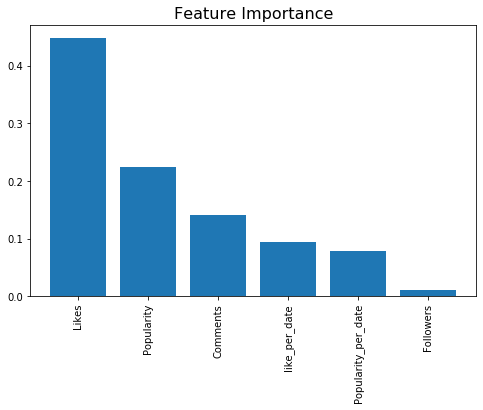

In [643]:
feature_importance = rf_regressor.feature_importances_
print(np.argsort(rf_regressor.feature_importances_))
indices = np.argsort(rf_regressor.feature_importances_)[::-1]
print(indices)
plt.figure(figsize=(8, 5))
plt.xticks(range(1,7), features_data.columns[indices], rotation=90)
plt.bar(range(1, 7), feature_importance[indices], align="center")
plt.title("Feature Importance", {"fontsize": 16});

In [527]:
xgb_regressor=xgb.XGBRegressor()

n_estimators = [100, 500]
max_depth = [2, 3, 5, 10, 15]
learning_rate=[0.05,0.1,0.15,0.20]
min_child_weight=[1,2,3,4]

# Define the grid of hyperparameters to search
hyperparameter_grid = {
    'n_estimators': n_estimators,
    'max_depth':max_depth,
    'learning_rate':learning_rate,
    'min_child_weight':min_child_weight,
    }

# Set up the random search with 4-fold cross validation
xgb_regressor_cv = RandomizedSearchCV(estimator=xgb_regressor,
            param_distributions=hyperparameter_grid,
            cv=2,
            scoring = 'neg_mean_absolute_error',
            return_train_score = True,
            random_state=42)
xgb_regressor_cv.fit(X_train,y_train)
xgb_regressor_cv.best_estimator_

[01:25:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:25:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:25:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:25:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:25:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:26:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:26:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:26:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:26:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.15, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=None, n_estimators=500,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

[10:35:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


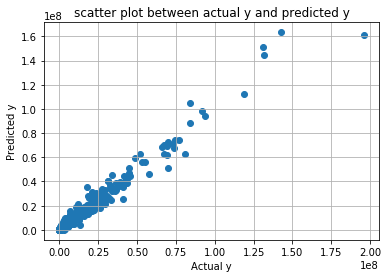

RMSE: 578839.153342


In [644]:
#regressor=xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=100, min_child_weight=3, max_depth=10, learning_rate=0.1, booster='gbtree', base_score=0.25)
xgb_regressor= xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.15, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=None, n_estimators=500,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)
xgb_regressor.fit(X_train,y_train)

preds = xgb_regressor.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
plt.scatter(y_test,preds)
plt.grid()
plt.xlabel('Actual y')
plt.ylabel('Predicted y')
plt.title('scatter plot between actual y and predicted y')
plt.show()
print("RMSE: %f" % (rmse))

In [645]:
#outliers
xgb_regressor.feature_importances_

array([0.00821262, 0.9730441 , 0.00794673, 0.00291876, 0.00519681,
       0.00268094], dtype=float32)

[3 4 2 0 1]
[1 0 2 4 3]


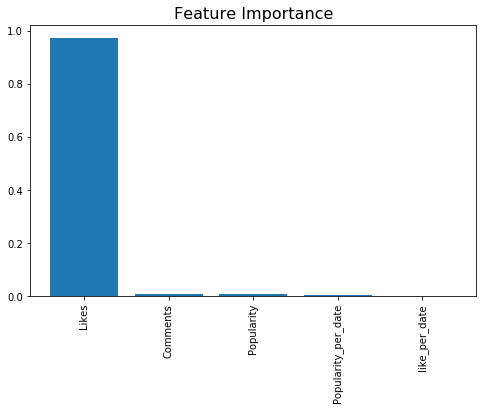

In [531]:
feature_importance = xgb_regressor.feature_importances_
print(np.argsort(xgb_regressor.feature_importances_))
indices = np.argsort(xgb_regressor.feature_importances_)[::-1]
print(indices)
plt.figure(figsize=(8, 5))
plt.xticks(range(1, 6), features_data.columns[indices], rotation=90)
plt.bar(range(1, 6), feature_importance[indices], align="center")
plt.title("Feature Importance", {"fontsize": 16});

In [532]:
estimators = {"Linear Regressor": lr_regressor,
              "Lasso Regressor": laso_regressor,
              "Random Forest Regressor": rf_regressor,
              "XGB Regressor": xgb_regressor}
for estimator in estimators.keys():
    print('RMSE {}:{:.2f}'.format(estimator,np.sqrt(mean_squared_error(y_test, estimators[estimator].predict(X_test)))))

RMSE Linear Regressor:694020.40
RMSE Lasso Regressor:694020.39
RMSE Random Forest Regressor:590069.23
RMSE XGB Regressor:585361.51


In [646]:
data_test = pd.read_csv('./data/Data_Test.csv')
label= data_test['Unique_ID']
data_test.drop(columns=['Unique_ID','Country','Name','Song_Name'],axis=1,inplace=True)
data_test['Likes'] = data_test.Likes.apply(popularityConverting)
data_test['Likes'] = data_test.Likes.astype('float')
data_test['Timestamp'] =pd.to_datetime(data_test['Timestamp'])
data_test['dayofweek'] = data_test['Timestamp'].dt.dayofweek #but mostly people on weekend
data_test['weekend'] = data_test['dayofweek'].apply(lambda x: 1 if (x>4)  else 0)
data_test['date_old']=(NOW-data_test['Timestamp']).dt.days
data_test['like_per_date']=data_test['Likes']/data_test['date_old']
data_test['followers_per_date']=data_test['Followers']/data_test['date_old']
data_test['Popularity'] = data_test.Popularity.apply(popularityConverting)
data_test['Popularity'] = data_test.Popularity.astype('float')
data_test['Popularity_per_date']=data_test['Popularity']/data_test['date_old']
X_testf = data_test.loc[:,['Comments', 'Likes', 'Popularity','like_per_date','Popularity_per_date','Followers']]
X_testf.head()

,Comments,Likes,Popularity,like_per_date,Popularity_per_date,Followers
0,26,5428.0,118.0,98.690909,2.145455,2568
1,18,738.0,195.0,0.508966,0.134483,155645
2,18,386.0,96.0,0.194263,0.048314,29446
3,1,388.0,19.0,0.092052,0.004508,799410
4,0,79.0,1.0,0.395000,0.005000,2


In [647]:
X_testf.shape

(19615, 6)

In [648]:
X_testf= sc.transform(X_testf)
display(len(X_testf))
Y_pred = xgb_regressor.predict(X_testf)
display(len(Y_pred))

19615

19615

In [649]:
print(Y_pred)
display(len(label))

[236565.38    31367.592   18585.975  ...   5931.5615  86918.26
  24189.26  ]


19615

In [650]:
sub_df = pd.read_excel('./data/Sample_Submission.xlsx') 
submission = pd.DataFrame({
        "Unique_ID": label,
        "Views": Y_pred
    })
submission.to_excel('./data/Sample_Submission_Final.xlsx',index=False)

In [552]:
from keras import backend as K
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

Using TensorFlow backend.


In [553]:
# Importing the Keras libraries and packages
import keras
from keras.wrappers.scikit_learn import KerasClassifier,KerasRegressor
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LeakyReLU,PReLU,ELU
from keras.layers import Dropout


# Function to create model, required for KerasClassifier
def create_model():
    # create mode
    model = Sequential()
    model.add(Dense( units=12, input_dim=5, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense( units=8, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(units = 1, kernel_initializer='he_uniform'))
    # Compile model
    model.compile(loss=root_mean_squared_error, optimizer='Adamax')
    return model
# create model
model = KerasRegressor(build_fn=create_model)

# Fitting the ANN to the Training set
model_history=model.fit(X_train, y_train,validation_split=0.30, batch_size = 10, epochs = 30)

Train on 38444 samples, validate on 16476 samples
Epoch 1/30
38444/38444 [==============================] - 4s 101us/step - loss: 1496765.4616 - val_loss: 1251386.9342
Epoch 2/30
38444/38444 [==============================] - 3s 87us/step - loss: 1511600.5893 - val_loss: 1250380.7990
Epoch 3/30
38444/38444 [==============================] - 3s 88us/step - loss: 1512076.3901 - val_loss: 1247510.0786
Epoch 4/30
38444/38444 [==============================] - 3s 89us/step - loss: 1511001.2817 - val_loss: 1242152.5033
Epoch 5/30
38444/38444 [==============================] - 3s 89us/step - loss: 1503439.3907 - val_loss: 1234788.4223
Epoch 6/30
38444/38444 [==============================] - 4s 91us/step - loss: 1490905.8418 - val_loss: 1228520.2300
Epoch 7/30
38444/38444 [==============================] - 4s 93us/step - loss: 1489882.2781 - val_loss: 1223805.4025
Epoch 8/30
38444/38444 [==============================] - 4s 102us/step - loss: 1484345.7436 - val_loss: 1220310.4408
Epoch 9/30
3

In [554]:
ann_pred=model.predict(X_test)

In [555]:
rmse = np.sqrt(mean_squared_error(y_test, ann_pred))
print("RMSE: %f" % (rmse))

RMSE: 3599415.252105
